In [2]:
%pip install gurobipy networkx 

Note: you may need to restart the kernel to use updated packages.


In [3]:
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from costgraph.EdgeFunctions import *

In [4]:
%%latex
Edge
\begin{gather}
\text{Edge Cost Function: }\\ 
\forall e \in E\\
f_{e}: \mathbb{R}^+ \rightarrow \mathbb{R}^+ \text{ where }\\
\forall x, y \in \mathbb{R}, x \geq y, f_e(x) \leq f_e(y)\\
\end{gather}

<IPython.core.display.Latex object>

In [5]:
costly_edge = EdgeCostLinear(6,2,3,10)
#cheap_edge = EdgeCostLinear(10,6,1,8)
cheap_edge = EdgeCostExponential(10,6,1,8,0.5)

In [15]:
def graphEdgeFunc(title: str, edge: EdgeCostFunction):
    
    title_fontsize = 24
    fontsize=20
    
    # Turn on TEX support
    plt.rcParams['text.usetex'] = True
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.set_facecolor((1,1,1))
    
    # Generate plot
    BB = np.linspace(0, 1.5 * (edge.b_min), 100)
    C = edge.f(BB)
    ax.plot(BB, C, label=edge.equation)
    ax.legend(fontsize=fontsize)
    
     # Set plot settings
    plt.ylim( 0.8 * edge.c_min, edge.c_init * 1.5)
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xlabel("Edge budget", fontsize=fontsize)
    ax.set_ylabel("Cost of Edge Traversal", fontsize=fontsize)
    plt.show()
    

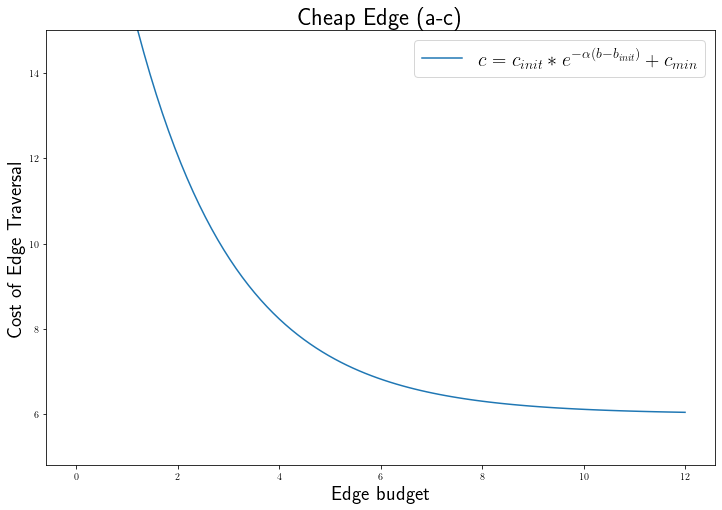

In [19]:
graphEdgeFunc("Cheap Edge (a-c)", cheap_edge)

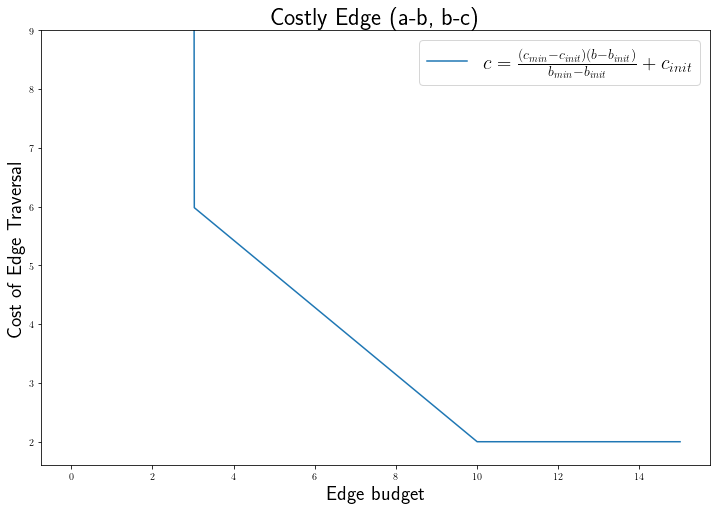

In [20]:
graphEdgeFunc("Costly Edge (a-b, b-c)", costly_edge)

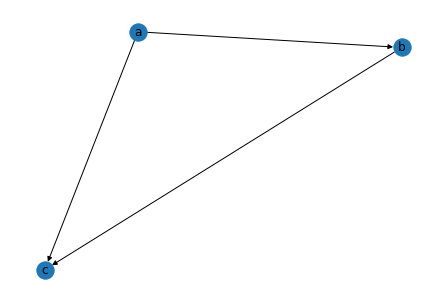

In [23]:
G = nx.DiGraph()
G.add_edge("a", "b", f=costly_edge)
G.add_edge("b", "c", f=costly_edge)
G.add_edge("a", "c", f=cheap_edge)
    
nx.draw(G, with_labels=True)

In [24]:
# MODEL PARAMETERS

start_node = 'a'
end_node = 'c'

# Budget for planning problem
#B = 22
B = 18
# Number of points in piecewise approximation of edge cost functions
n = 100

#TODO 10 didn't work? Might be an approximation error

In [25]:
m = gp.Model('SP')

arcs, costs = gp.multidict(((u, v), d["f"]) for (u, v, d) in G.edges(data=True))

x = m.addVars(arcs, vtype=GRB.BINARY, name ="path")
b = m.addVars(arcs, vtype=GRB.CONTINUOUS, ub=B, name="budget")
f = m.addVars(arcs, vtype=GRB.CONTINUOUS, name="aux_f")

for (u, v) in costs:
    b_min = costs.select(u,v)[0].b_min
    budget_pts = np.linspace(0, b_min+2, n)
    cost_pts = costs.select(u,v)[0].f(budget_pts)
    m.addGenConstrPWL(b[u,v], f[u,v], budget_pts, cost_pts)

m.setObjective(
    gp.quicksum(
        f[u,v]  * x[u,v] for (u, v) in G.edges), GRB.MINIMIZE)

for i in G.nodes:
    m.addConstr( gp.quicksum(x[i,j] for i,j in arcs.select(i, '*')) - gp.quicksum(x[j,i] for j,i in arcs.select('*',i)) == 
                     (1 if i==start_node else -1 if i==end_node else 0 ),'node%s_' % i )
m.addConstr(gp.quicksum(b[u,v]*x[u,v] for (u,v) in G.edges) <= B)


m.addConstr(gp.quicksum(b[u,v]*x[u,v] for (u,v) in G.edges) <= B)

m.optimize()

if m.status == GRB.Status.OPTIMAL:
    total_cost = 0
    for i,j in arcs:
        if x[i,j].x > 0:
            b_cur  = b[i,j].x
            c_cur = costs.select(i,j)[0].f(b_cur)
            print(f"{i}->{j}, b: {b_cur}, c: {c_cur}")
            total_cost += c_cur
            
    print(f"Total cost: {total_cost}")

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 3 rows, 9 columns and 6 nonzeros
Model fingerprint: 0x74eb141c
Model has 3 quadratic objective terms
Model has 2 quadratic constraints
Model has 3 general constraints
Variable types: 6 continuous, 3 integer (3 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 1e+00]
  QRHS range       [2e+01, 2e+01]
  PWLCon x range   [1e-01, 1e+01]
  PWLCon y range   [2e+00, 1e+02]
Presolve added 48 rows and 317 columns
Presolve time: 0.01s
Presolved: 54 rows, 329 columns, 4235 nonzeros
Variable types: 307 continuous, 22 integer (4 binary)
Found heuristic solution: objective 100.0000000

Root relaxation: objective 4.009171e+00, 51 iterations, 0.00 seconds (0.00 work units)


In [26]:
if m.status == GRB.Status.OPTIMAL:
    total_cost = 0
    total_budget = 0
    for i,j in arcs:
        if x[i,j].x > 0:
            b_cur  = b[i,j].x
            c_cur = costs.select(i,j)[0].f(b_cur)
            print(f"{i}->{j}, b: {b_cur}, c: {c_cur}")
            total_cost += c_cur
            total_budget += b_cur
            
    print(f"Total cost: {total_cost}")
    print(f"Total budget used: {total_budget}")

a->b, b: 9.878787878787879, c: 2.0692640692640696
b->c, b: 8.121212121212121, c: 3.0735930735930737
Total cost: 5.142857142857143
Total budget used: 18.0


In [20]:
for i, j in arcs:
    print(b[i,j].x)

10.181818181818182
8.686868686868687
10.787878787878789
